## Residential Housing Stock Forecast
The addition of new households is one of the largest drivers of growth for the Residential sector load forecast. To forecast new housing stock additions we estimate an econometric model that links new premises from City Light's billing system with key macroeconomic indicators for the Seattle Metropolotan area provided from City of Seattle Budget Office (CBO). 

```{admonition} What's a Premise?
:class: tip
A premise is a City Light specific term that refers to a unique identification number that is associated with a specific building structure in the billing system. 
A Residential premise is classified as Residential based on its rate schedule. We count the number of premises based on the number that have received bills over a given period.
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from myst_nb import glue

In [2]:
# read in global dates
start_date = '01-01-2005'
end_date = '12-31-2019'
fcast_date = '01-01-2020'

# CREATE CBO DATA

# bring in CBO data from excel
cbo_dates = pd.read_excel(
    './inputs/building_stock/CBO_EcoForecast_2020Q3_2020-07-31.xlsx',
    sheet_name = 'Baseline QTR',
    usecols = 'C:GT',
    skiprows = 3,
    nrows = 1,
    header = None
)

# building permits
cbo_permits = pd.read_excel(
    './inputs/building_stock/CBO_EcoForecast_2020Q3_2020-07-31.xlsx',
    sheet_name = 'Baseline QTR',
    usecols = 'C:GT',
    skiprows = 30,
    nrows = 1,
    header = None
)

# populate
cbo_pop = pd.read_excel(
    './inputs/building_stock/CBO_EcoForecast_2020Q3_2020-07-31.xlsx',
    sheet_name = 'Baseline QTR',
    usecols = 'C:GT',
    skiprows = 31,
    nrows = 1,
    header = None
)

cbo_df = pd.DataFrame({
    'Permits': cbo_permits.values[0] * 1000, 
    'Population': cbo_pop.values[0] * 1000, 
}, index=pd.to_datetime(cbo_dates.values[0]) - pd.tseries.offsets.MonthEnd(1))

# create lag parms
for i in np.arange(1,8):
    cbo_df['Population_l{}'.format(i)] = cbo_df['Population'].shift(periods=-i)
    cbo_df['Permits_l{}'.format(i)] = cbo_df['Permits'].shift(periods=-i)
    
# take first difference of population
pop_cols = [col for col in cbo_df.columns if 'Population' in col]
for i in pop_cols:
    cbo_df[i] = cbo_df[i].diff()
    
cbo_df = cbo_df.fillna(method='ffill')

In [3]:
# CREATE CITY LIGHT PREMISE DATA
scl_prems = pd.read_csv('./inputs/building_stock/prem_count.csv', parse_dates=['PRORATE_DATE'])
scl_prems = scl_prems.groupby(['CUSTOMER_CLASS', 'PREM_TYPE_CD', 'PRORATE_DATE'])['PREM_COUNT'].sum()
scl_prems_t = scl_prems.groupby(['CUSTOMER_CLASS', 'PRORATE_DATE']).sum()

# get building type weights for residential
scl_res = scl_prems.loc['RESIDENTIAL', ['SINFAM', 'APT'], :]
scl_res = scl_res.div(scl_res.loc['RESIDENTIAL'].groupby('PRORATE_DATE').sum())
scl_res = scl_res.mul(scl_prems_t['RESIDENTIAL']).to_frame().reset_index()
scl_res = scl_res.pivot(index='PRORATE_DATE', columns='PREM_TYPE_CD', values='PREM_COUNT')

# get residential quarterly
scl_res = scl_res.resample('Q').mean().diff().loc[start_date:end_date].reset_index()
scl_res['PRORATE_DATE'] = scl_res['PRORATE_DATE']
scl_res = scl_res.set_index('PRORATE_DATE')
scl_res = scl_res.rename(columns={'SINFAM': 'Single-Family', 'APT': 'Multi-Family'})

### City Light Premises vs Seattle Metro Population and Permits
We will treat 2 indicators from CBO's economic forecast as exogenous variables to predict new City Light Premise additions:
1. Seattle Metro Population
2. Building Permits

These 2 indicators have been graphed in {numref}`Figure {number} <premise_graph>` below. The Population and Building Permit data show a noticeable downturn after the 2009 recession but have been running strong for the 
last 5 years. City Light's Mult-Family Premise counts appear to follow a similar economic cycle as Population and Building Permits. Single-Family does not appear to track the macroeconomic indicators as closely as Multi-Family.

```{admonition} Multi-Family vs Single-Family Premise Growth
:class: tip
Growth in Multi-Family building stock has been much stronger than Single-Family in City Light's service territory since 2009. 
Seattle has limited undeveloped land which limit new Single-Family construction. Seattle has been growing up not out.
```

```{glue:figure} premise_graph
:name: "premise_graph"
Quarterly Population and Building Permit data from CBO and Premise counts from City Light billing data for 2005 - 2019.
```

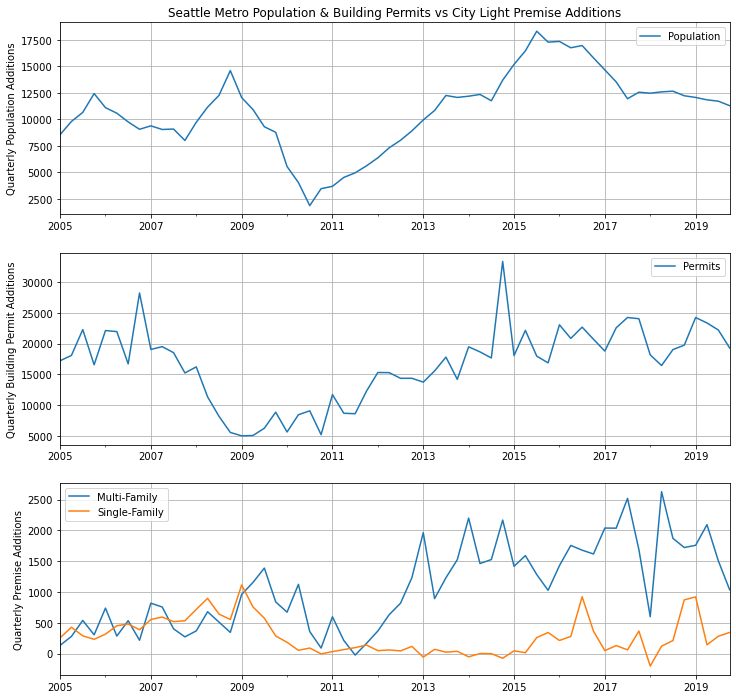

In [6]:
cbo_scl = cbo_df.loc[start_date:end_date].join(scl_res)

import warnings
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,12))
cbo_scl['Population'].plot(ax=axs[0],  legend=True, grid=True)
cbo_scl['Permits'].plot(ax=axs[1], legend=True, grid=True)
cbo_scl.filter(regex='Family').plot(ax=axs[2], grid=True)
axs[0].set_title('Seattle Metro Population & Building Permits vs City Light Premise Additions')
axs[0].set_ylabel('Quarterly Population Additions')
axs[1].set_ylabel('Quarterly Building Permit Additions')
axs[2].set_ylabel('Quarterly Premise Additions')
glue('premise_graph', fig, display=False)

### Develop Premise Models Using ARIMAX
To model both Multi-Family and Single Family premises we will use a type of timeseries model called an [**ARIMAX**](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average). An [**ARIMAX**](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model provides the machanics needed to handle some tricky properties of timeseries which can't be performed using a more traditional regression. The **X** in [**ARIMAX**](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) denotes that the model can also except exogenous inputs (independent variables) like Population and Building Stock data.

We will use a Python package called called [**Statsmodels**](https://www.statsmodels.org/stable/index.html) which has robust timeseries modelling capabilities. The [**SARIMAX**](https://www.statsmodels.org/stable/index.html) model can be used to define an **ARIMAX** model which we will do for both Multi-Family and Single-Family in the sections that follow.

#### Multi-Family Premise ARIMAX Model
We will specify the Multi-Family Premise (***MF***) model with Building Permits (***BP***) as an exogenous input. The error is assumed to follow an ***ARMA*** (1,1) process. Note that Premise counts and Building Permits are effectively already in first-differences meaning that the ***I*** step in the ***ARIMAX*** model is not needed. Trial and error was used to determine that (***BP***) and the 7 quarter lag (***BP***) had the strongest relationship with (***MF***).

```{math}
:label: multi_prem_eq
MF_t = \beta_0 BP_t + \beta_1 BP_{t-7} + \mu_t \\
(1-\theta_{1} L) \mu_t = (1 - \theta_{1} L) \epsilon_t
```

```{glue:figure} mf_fit_graph
:name: "mf_fit_graph"
Predicted in-sample quarterly Multi-Family Premise additions based on fitted ARIMAX model.
```

                           Statespace Model Results                           
Dep. Variable:           Multi-Family   No. Observations:                   60
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -449.906
Date:                Mon, 24 Aug 2020   AIC                            909.812
Time:                        15:37:42   BIC                            920.283
Sample:                    03-31-2005   HQIC                           913.908
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Permits        0.0311      0.015      2.059      0.039       0.001       0.061
Permits_l7     0.0211      0.010      2.075      0.038       0.001       0.041
ar.L1          0.9082      0.066     13.859      0.0

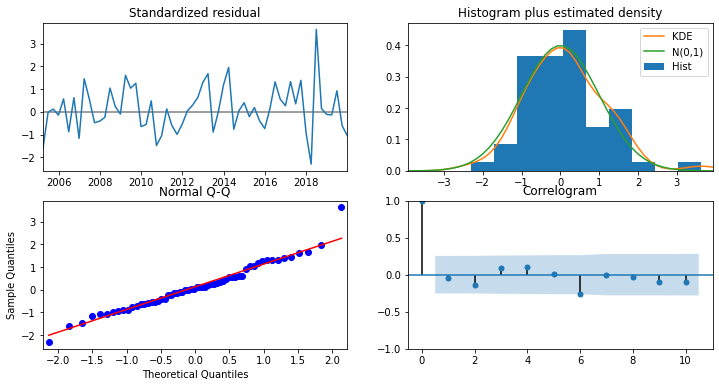

In [25]:
# create lag parameters
fit = {}
res_mf_mod = sm.tsa.statespace.SARIMAX(cbo_scl['Multi-Family'], 
                                    cbo_scl[['Permits', 'Permits_l7']], 
                                    order=(1,0,1))
fit['Multi-Family'] = res_mf_mod.fit()
print(fit['Multi-Family'].summary())
diag = fit['Multi-Family'].plot_diagnostics(figsize=(12,6))

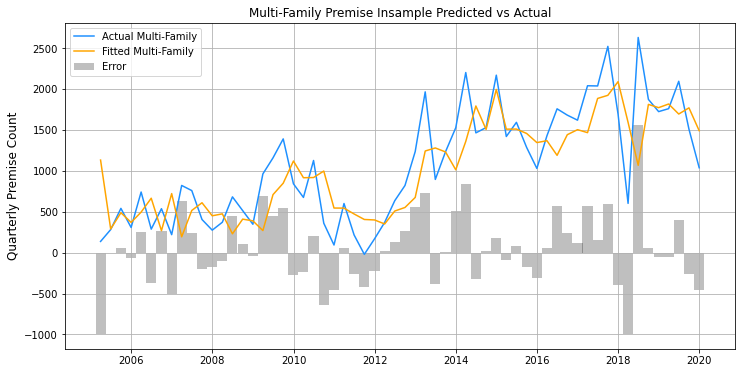

In [26]:
fig, ax = plt.subplots(figsize=(12,6))

actual = ax.plot(cbo_scl['Multi-Family'].index, cbo_scl['Multi-Family'], 
                 color='#1e90ff', label='Actual Multi-Family')
fitted = ax.plot(fit['Multi-Family'].fittedvalues.index, fit['Multi-Family'].fittedvalues, 
              color='#ffa500', label='Fitted Multi-Family')
error = ax.bar(fit['Multi-Family'].resid.index, fit['Multi-Family'].resid, width=1, alpha=0.25,
              color='black', label='Error')

ax.set_title('Multi-Family Premise Insample Predicted vs Actual')
ax.legend()
plt.ylabel('Quarterly Premise Count', fontsize=12)
plt.grid()
plt.show()

glue('mf_fit_graph', fig, display=False)

#### Single-Family Premise ARIMAX Model
We will specify the Single-Family Premise (***SF***) model with Population (***POP***) an exogenous input. The error term is assumed to follow an ***ARMA*** (1,1) process. Trial and error was used to determine that (***POP***) had the strongest relationship with (***SF***).

```{math}
:label: single_prem_eq
SF_t = \beta_0 POP_t + \mu_t \\
(1-\theta_{1} L) \mu_t = (1 - \theta_{1} L) \epsilon_t
```

```{glue:figure} sf_fit_graph
:name: "sf_fit_graph"
Predicted in-sample quarterly Single-Family Premise additions based on fitted ARIMAX model.
```

                           Statespace Model Results                           
Dep. Variable:          Single-Family   No. Observations:                   60
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -408.094
Date:                Mon, 24 Aug 2020   AIC                            824.187
Time:                        15:49:15   BIC                            832.565
Sample:                    03-31-2005   HQIC                           827.464
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population     0.0266      0.011      2.326      0.020       0.004       0.049
ar.L1          0.8401      0.091      9.251      0.000       0.662       1.018
ma.L1         -0.3747      0.147     -2.551      0.0

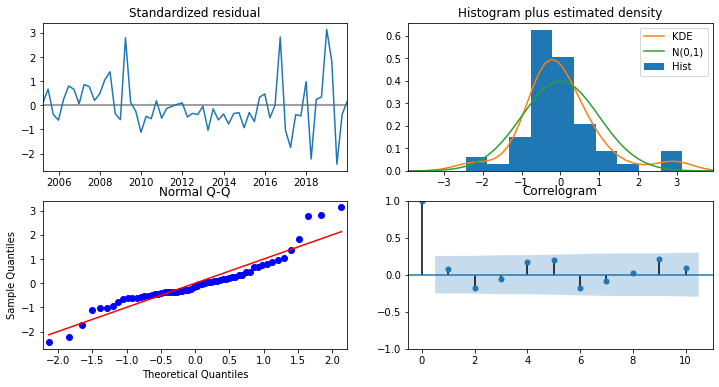

In [27]:
res_sf_mod = sm.tsa.statespace.SARIMAX(cbo_scl['Single-Family'], 
                                    cbo_scl['Population'], 
                                    order=(1,0,1))
fit['Single-Family'] = res_sf_mod.fit()
print(fit['Single-Family'].summary())
diag = fit['Single-Family'].plot_diagnostics(figsize=(12,6))

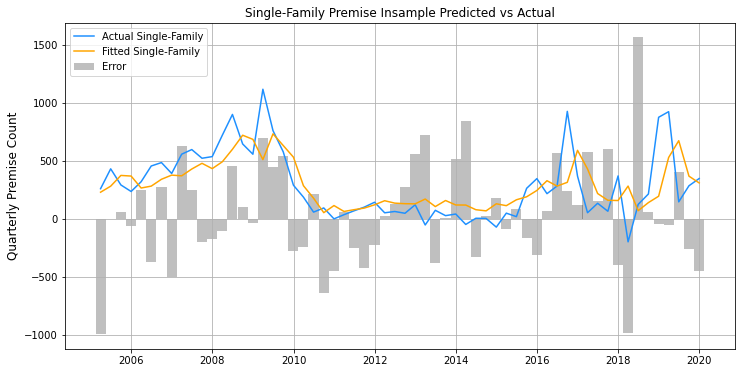

In [30]:
fig, ax = plt.subplots(figsize=(12,6))

actual = ax.plot(cbo_scl['Single-Family'].index, cbo_scl['Single-Family'], 
                 color='#1e90ff', label='Actual Single-Family')
fitted = ax.plot(fit['Single-Family'].fittedvalues.index, fit['Single-Family'].fittedvalues, 
              color='#ffa500', label='Fitted Single-Family')
diff = ax.bar(fit['Multi-Family'].resid.index, fit['Multi-Family'].resid, width=1, alpha=0.25,
              color='black', label='Error')

ax.set_title('Single-Family Premise Insample Predicted vs Actual')
ax.legend()
plt.ylabel('Quarterly Premise Count', fontsize=12)
plt.grid()
plt.show()

glue('sf_fit_graph', fig, display=False)

### Make Multi-Family and Single-Family Predictions for 2021 - 2040

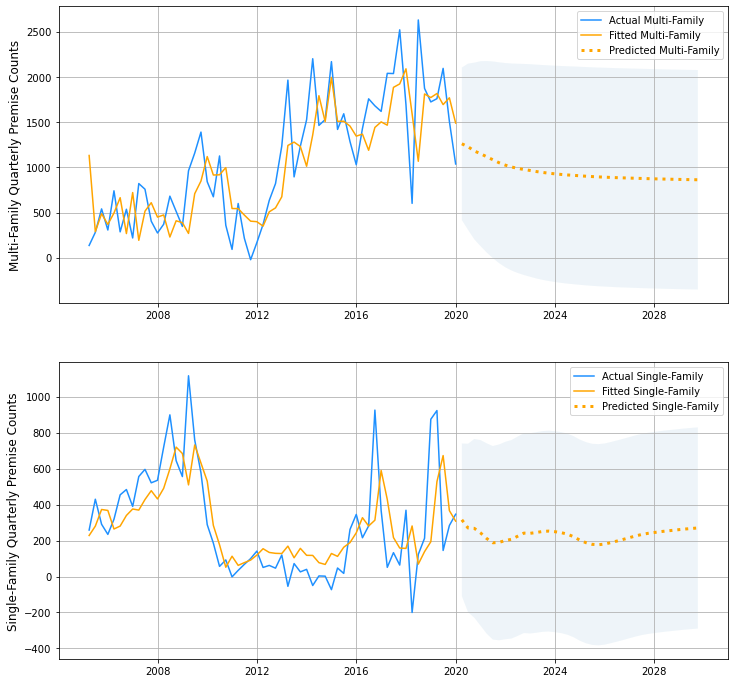

In [31]:
preds = {}
preds['Multi-Family'] = fit['Multi-Family'].get_prediction(
    start='03-31-2020', end='09-30-2029', exog=cbo_df.loc[fcast_date:, ['Permits', 'Permits_l7']])
preds['Single-Family'] = fit['Single-Family'].get_prediction(
    start='03-31-2020', end='09-30-2029', exog=cbo_df.loc[fcast_date:, ['Population']])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12))

for i, (key, val) in enumerate(preds.items()):
    actual = ax[i].plot(cbo_scl[key].index, cbo_scl[key], 
                     color='#1e90ff', label=f'Actual {key}')

    fitted = ax[i].plot(fit[key].fittedvalues.index, fit[key].fittedvalues, 
                  color='#ffa500', label=f'Fitted {key}')

    pred = ax[i].plot(preds[key].predicted_mean.index, preds[key].predicted_mean, linewidth=3,
                     linestyle=':', color='#ffa500', label=f'Predicted {key}')
    
    cis = preds[key].conf_int(alpha=0.05)
    
    pred = ax[i].fill_between(cis.index, cis.iloc[:, 0], cis.iloc[:, 1], alpha=0.075)
    
    ax[i].set_ylabel(f'{key} Quarterly Premise Counts', fontsize=12)
    ax[i].legend()
    ax[i].grid()

plt.show()